In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 10
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 2
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [3]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pancreas_shrinked.h5ad'
)
condition_key = 'study'
reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]

In [4]:
adata = remove_sparsity(adata)

indices = np.arange(len(adata))
#stratified label/unlabeled split
if unlabeled_strat == "batch":
    labeled_ind = indices[adata.obs.study.isin(reference)].tolist()
    labeled_adata = adata[adata.obs.study.isin(reference)].copy()
    unlabeled_adata = adata[adata.obs.study.isin(query)].copy()
if unlabeled_strat == "ct":
    labeled_ind = []
    cts = adata.obs[cell_type_key[0]].unique().tolist()
    for celltype in cts:
        ct_indices = indices[adata.obs[cell_type_key[0]].isin([celltype])]
        ct_sel_ind = np.random.choice(ct_indices, size=cells_per_ct, replace=False)
        labeled_ind += ct_sel_ind.tolist()
        print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))
    unlabeled_ind = np.delete(indices, labeled_ind).tolist()
    labeled_adata = adata[labeled_ind].copy()
    unlabeled_adata = adata[unlabeled_ind].copy()

In [5]:
embed = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = ['decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [6]:
embed.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=100,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████████████████----| 80.0%  - val_loss: 1145.8923245944 - val_trvae_loss: 1145.8923245944
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 31 clusters.
 |█████████████████---| 87.2%  - val_loss: 1195.0486309345 - val_trvae_loss: 1161.1667949970 - val_classifier_loss: 33.8818336267 - val_unlabeled_loss: 0.5548507250 - val_labeled_loss: 0.3382634884
ADJUSTED LR
 |█████████████████---| 88.6%  - val_loss: 1189.1458176833 - val_trvae_loss: 1158.4104942909 - val_classifier_loss: 30.7353020631 - val_unlabeled_loss: 0.5511431442 - val_labeled_loss: 0.3068018795
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 421


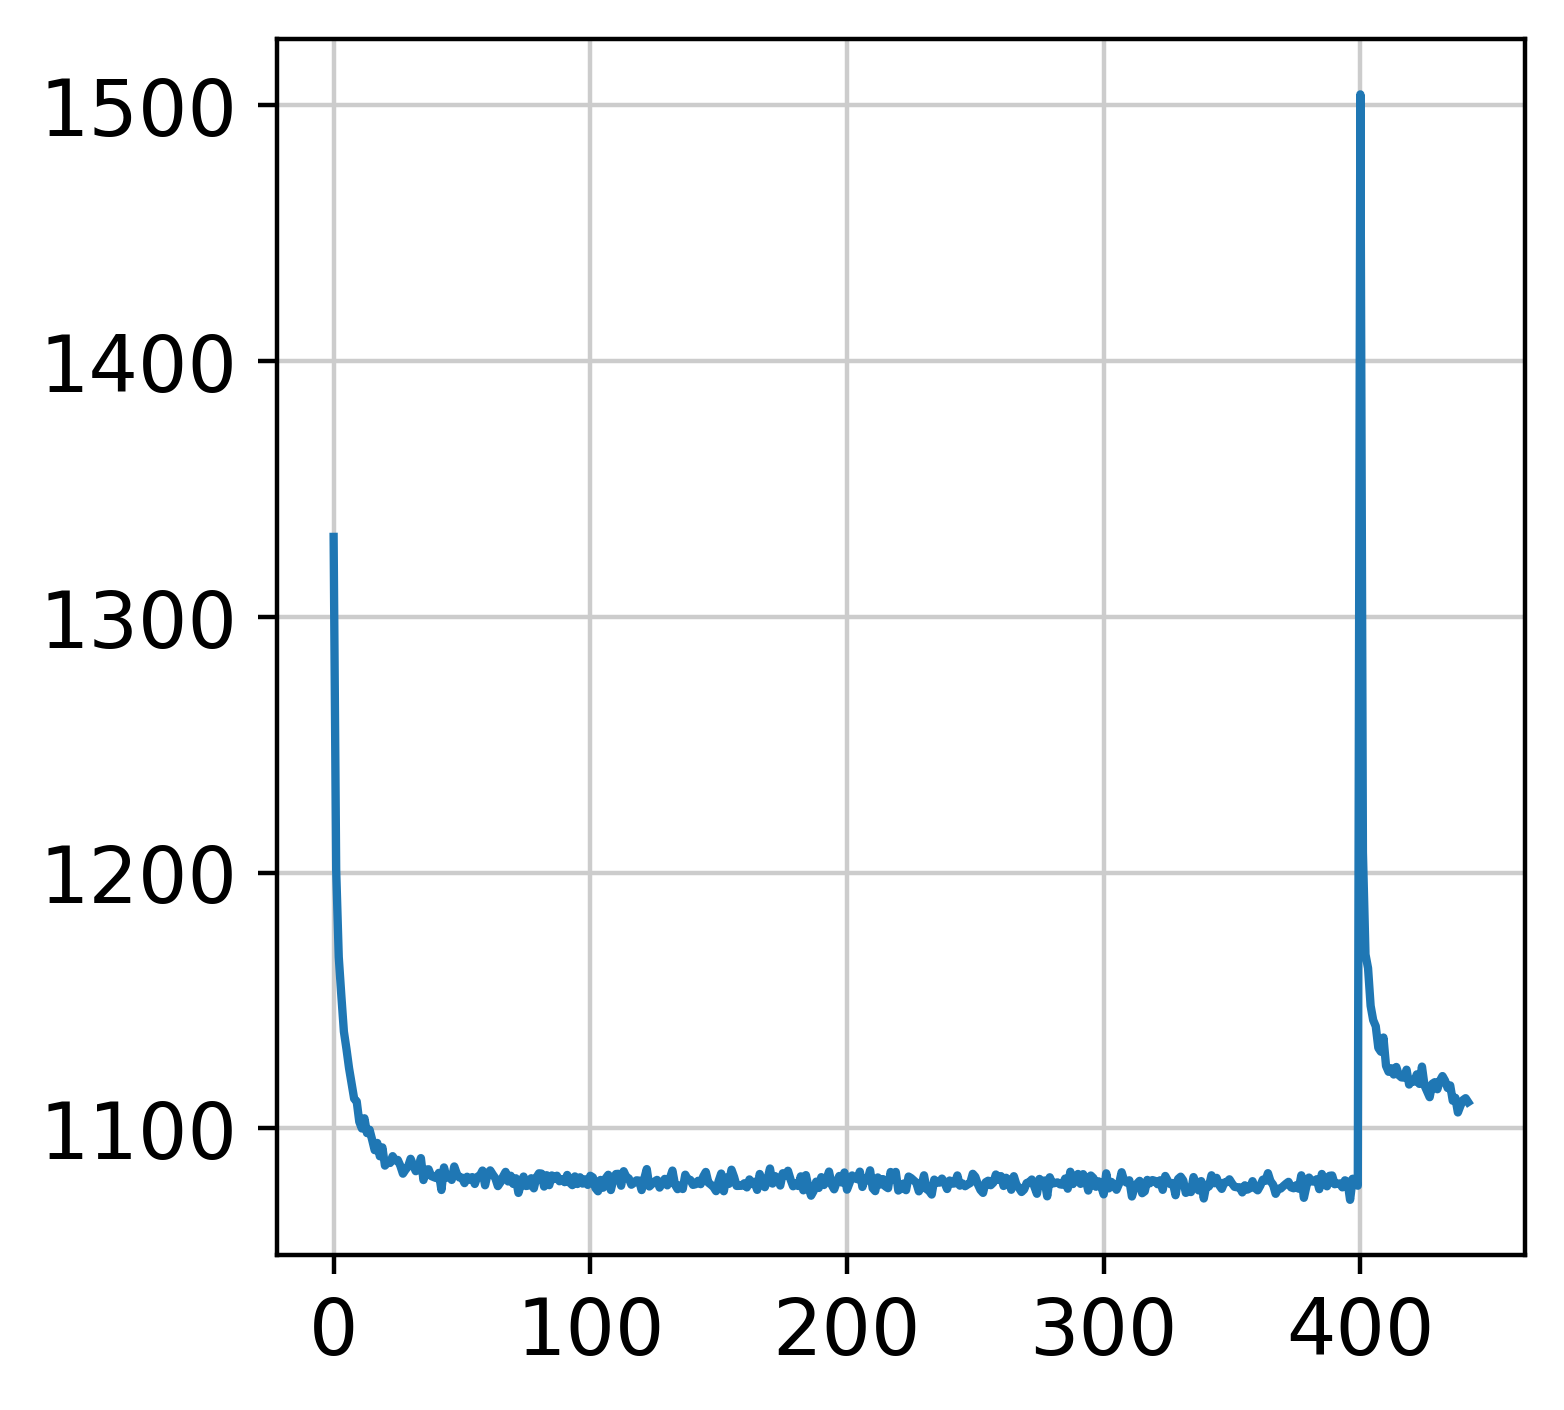

In [7]:
plt.plot(embed.trainer.logs['epoch_loss'])

In [ ]:
data_latent = embed.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed_dec = sc.AnnData(data_latent)
adata_latent_embed_dec.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed_dec = embed.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_dec)
sc.pp.neighbors(adata_latent_embed_dec)
sc.tl.umap(adata_latent_embed_dec)
sc.pl.umap(adata_latent_embed_dec, color='batch')

In [ ]:
embedding = embed.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)



In [ ]:
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], embed.conditions_)

NameError: name 'adata_latent' is not defined

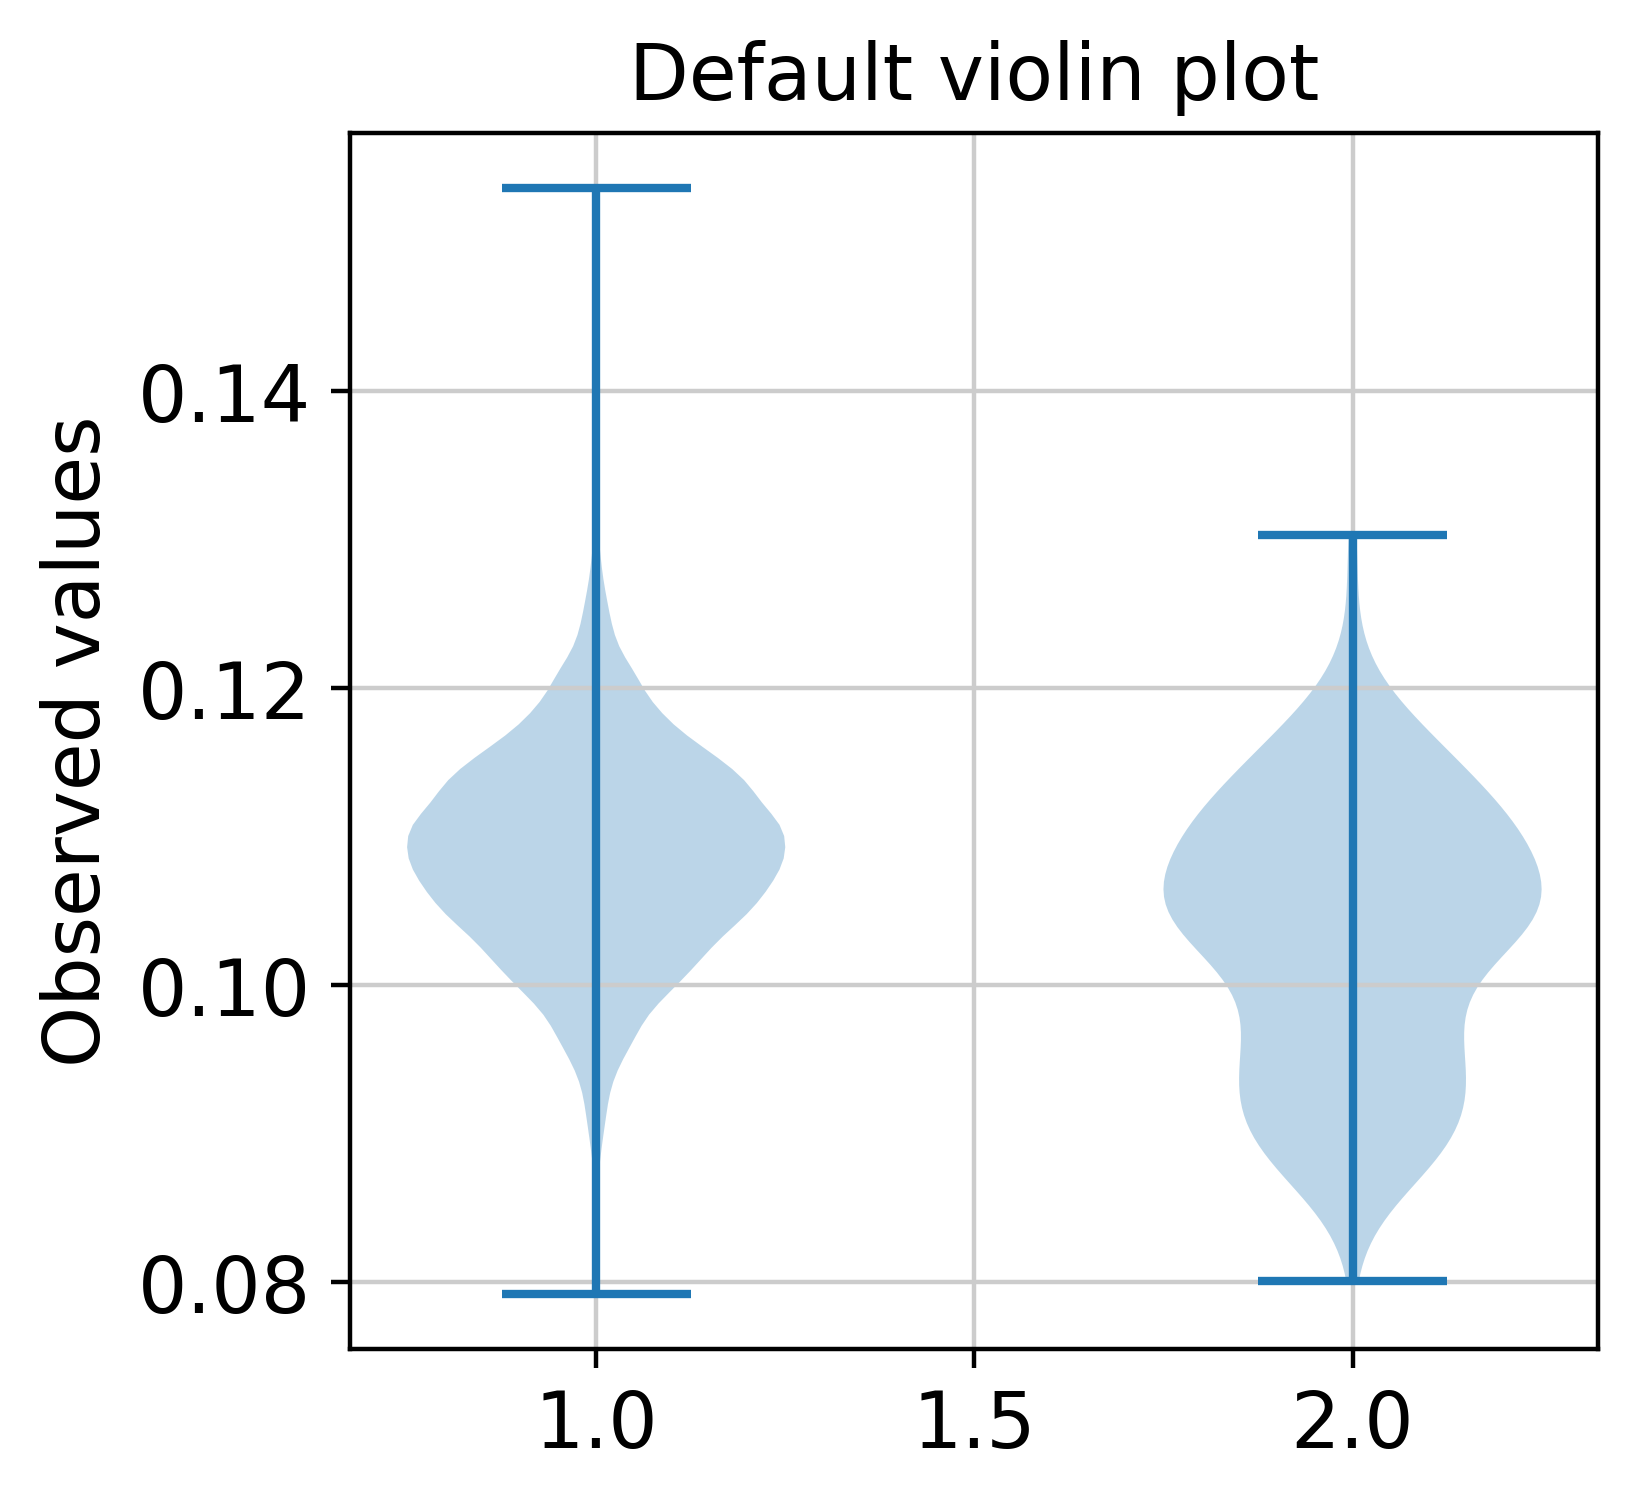

In [28]:
for i in range(len(cell_type_key)):
    preds = results_dict[i]['preds']
    probs = results_dict[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()

NameError: name 'adata_latent' is not defined

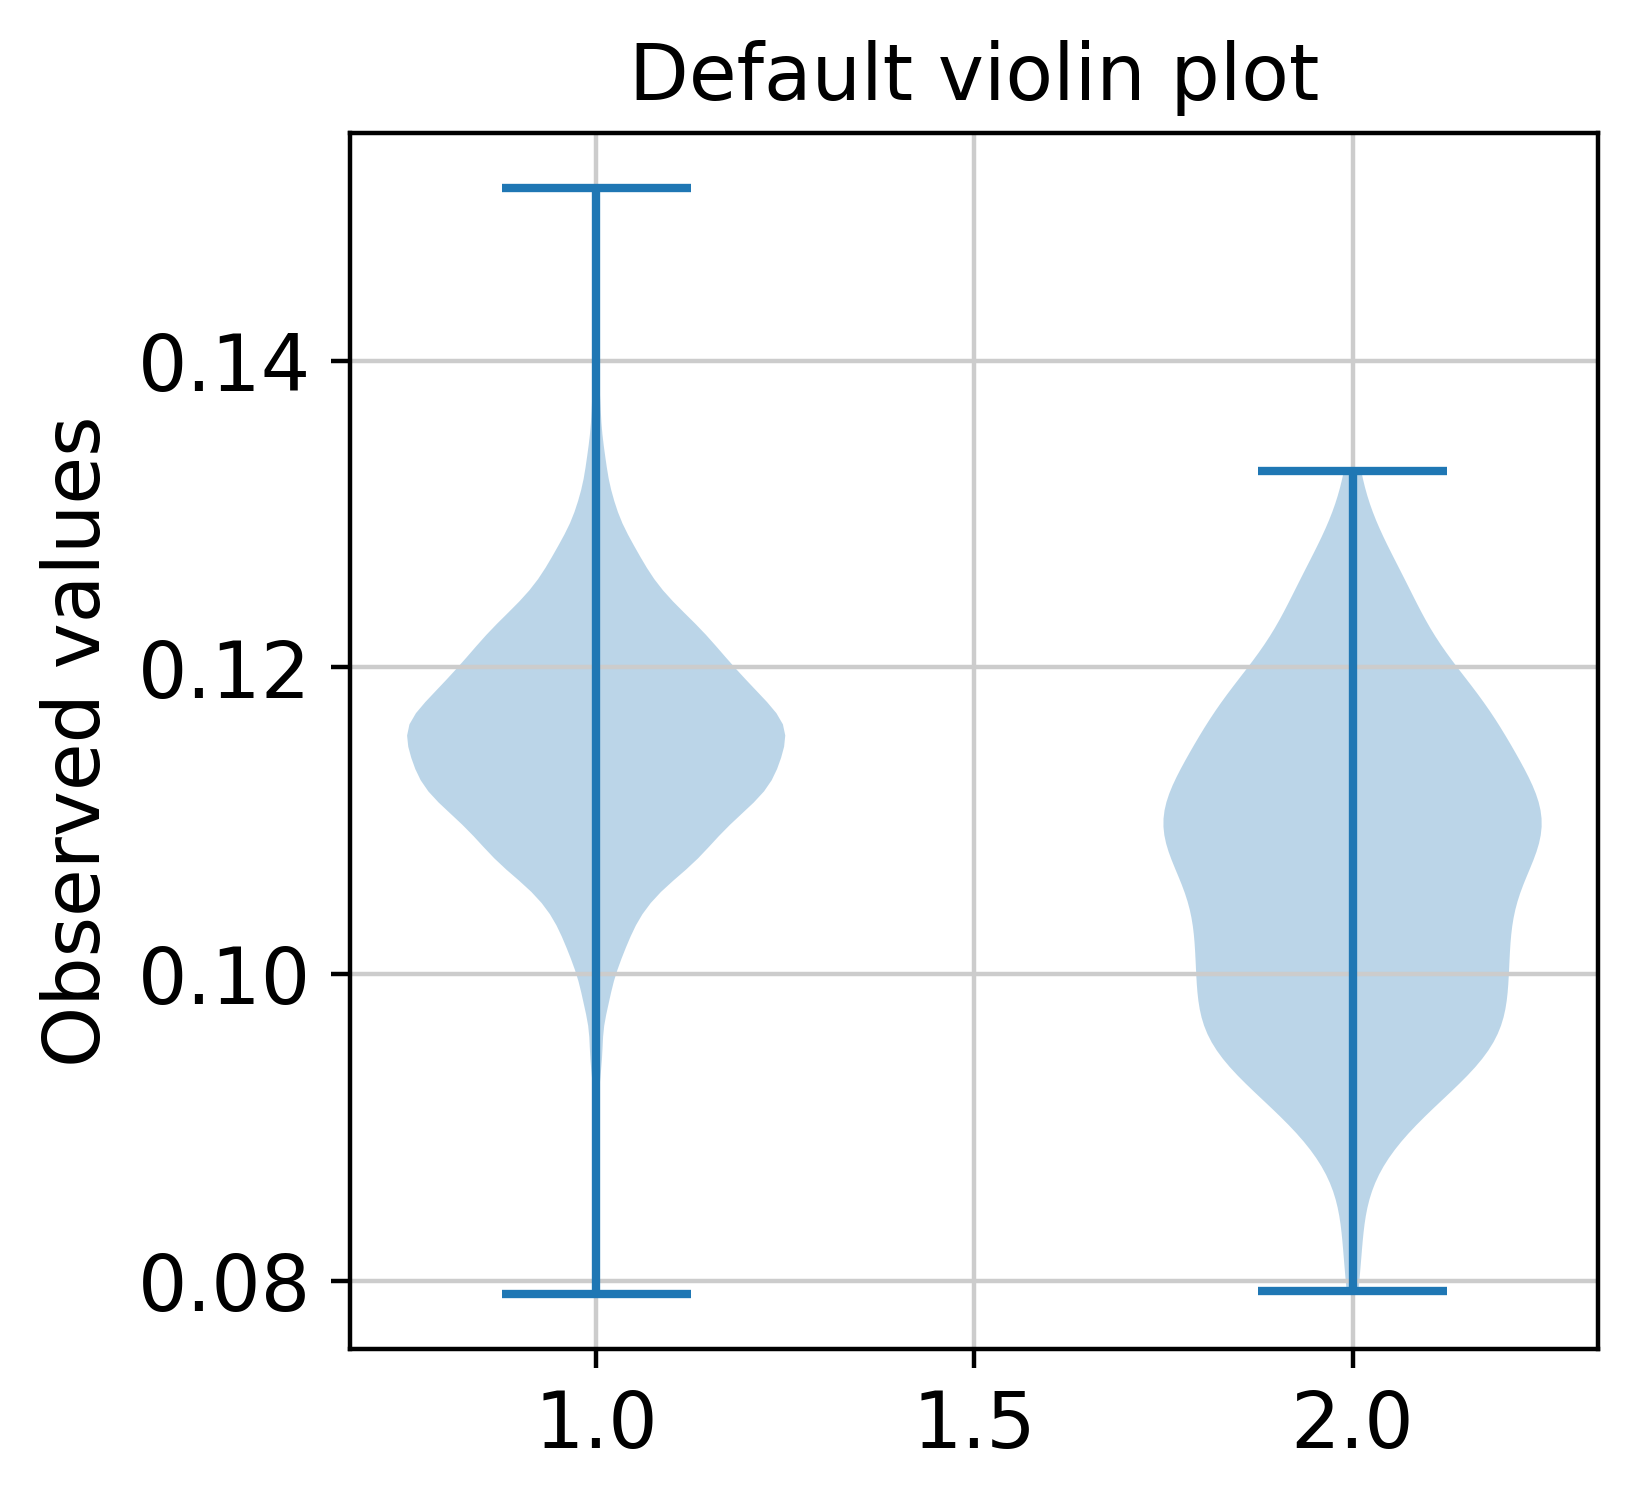

In [30]:
for i in range(len(cell_type_key)):
    preds = results_dict_embed[i]['preds']
    probs = results_dict_embed[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()